
# 1. Подготовка данных к анализу и построению моделей

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import xgboost

%pylab inline

/home/as/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_RMSLE(predicted_l, actual_l):
    p_ = np.array(predicted_l)
    a_ = np.array(actual_l)
    ret_val = np.sqrt(np.sum((np.log(p_+1)-np.log(a_+1))**2)/len(p_))
    return ret_val

def to_log(arr):
    arr_ = np.array(arr)
    return np.log(arr_+1)

def from_log(arr):
    arr_ = np.array(arr)
    return np.exp(arr_)-1

In [3]:
root_path = '/home/as/Desktop/machine learning/___kaggle/SberbankRussianHousingMarket'

In [4]:
train_data = pd.read_csv(root_path+'/data/train.csv', index_col='id')

### Макроэкономика

In [6]:
macro_df = pd.read_csv(root_path+'/data/macro.csv')
m_timestamp_col = pd.to_datetime(macro_df['timestamp'])
macro_ts_df = pd.DataFrame(index=macro_df.index,columns=['year','month','day'])
macro_ts_df['year']  = [x.year  for x in m_timestamp_col]
macro_ts_df['month'] = [x.month for x in m_timestamp_col]
macro_ts_df['day']   = [x.day   for x in m_timestamp_col]
macro_df = pd.concat((macro_df,macro_ts_df),axis=1)

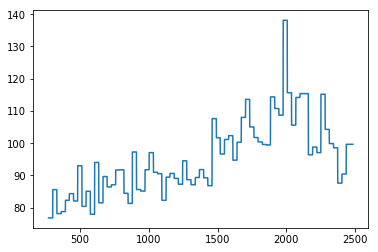

In [7]:
plot(macro_df['rent_price_3room_bus'])

In [8]:
r_avg = []
j=0
for y_ in np.unique(macro_ts_df['year']):
        for m_ in np.unique(macro_ts_df['month'][macro_ts_df['year']==y_]):
            r_avg.append(np.mean(macro_df['usdrub'][(macro_df['year']==y_)&(macro_df['month']==m_)]))
            j+=1
            if j>=56 and j<=60:
                print(y_,m_,r_avg[len(r_avg)-1])

r_diff = [(r_avg[i+1]-r_avg[i]) for i in range(len(r_avg)-1)]
print(max(r_diff),argmax(r_diff))

2014 8 36.2054419355
2014 9 38.0360033333
2014 10 40.8895225806
2014 11 46.35799
2014 12 56.4569387097
10.0989487097 58


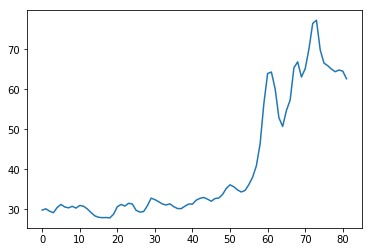

In [9]:
plot(r_avg)
#plot(r_diff)

In [10]:
def get_usdrub_df(dataset_=train_data):
    ret_df = pd.DataFrame(data=0,index=dataset_.index,columns=['usdrub','diff_usdrub'])
    
    timestamp_col = pd.to_datetime(dataset_['timestamp'])
    ds_ts_df = pd.DataFrame(index=dataset_.index,columns=['year','month','day'])
    ds_ts_df['year']  = [x.year  for x in timestamp_col]
    ds_ts_df['month'] = [x.month for x in timestamp_col]
    ds_ts_df['day']   = [x.day   for x in timestamp_col]
    
    ret_df['usdrub'][(ds_ts_df['year']>=2014) & (ds_ts_df['month']>=11)] = 1
    ret_df['usdrub'][(ds_ts_df['year']>=2015)] = 1
    
    val0_ = np.mean(macro_df['usdrub']\
                    [(macro_ts_df['year']==min(np.unique(macro_ts_df['year']))) & \
                     (macro_ts_df['month']==min(np.unique(macro_ts_df['month'][macro_ts_df['year']==min(np.unique(macro_ts_df['year']))])))]\
                    .dropna())
    for y_ in np.unique(macro_ts_df['year']):
        for m_ in np.unique(macro_ts_df['month'][macro_ts_df['year']==y_]):
            val_ = np.mean(macro_df['usdrub'][(macro_ts_df['year']==y_) & (macro_ts_df['month']==m_)].dropna())
            ret_df['diff_usdrub'][(ds_ts_df['year']==y_) & (ds_ts_df['month']==m_)] = val_ - val0_
            val0_ = val_
            #ret_df['usdrub'][(ds_ts_df['year']==y_) & (ds_ts_df['month']==m_)] = val_
            #for d_ in np.unique(macro_ts_df['day'][(macro_ts_df['year']==y_) & (macro_ts_df['month']==m_)]):
            #    val_ = float(macro_df['usdrub'][(macro_ts_df['year']==y_) & (macro_ts_df['month']==m_) & (macro_ts_df['day']==d_)])
            #    if val_>0:
            #        ret_df['usdrub'][(ds_ts_df['year']==y_) & (ds_ts_df['month']==m_) & (ds_ts_df['day']==d_)] = val_
    
    return ret_df

In [11]:
usdrub_df = get_usdrub_df()

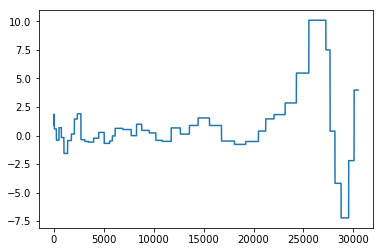

In [12]:
plot(usdrub_df['diff_usdrub'])

In [13]:
def get_macro_df(col_name_list, dataset_=train_data):
    timestamp_col = pd.to_datetime(dataset_['timestamp'])
    ds_ts_df = pd.DataFrame(index=dataset_.index,columns=['year','month','day'])
    ds_ts_df['year']  = [x.year  for x in timestamp_col]
    ds_ts_df['month'] = [x.month for x in timestamp_col]
    ds_ts_df['day']   = [x.day   for x in timestamp_col]
    
    print(col_name_list)
    ret_df = pd.DataFrame(data=0,index=dataset_.index,columns=col_name_list)
    
    for col_ in col_name_list:
        print(col_)
        for y_ in np.unique(macro_ts_df['year']):
            for m_ in np.unique(macro_ts_df['month'][macro_ts_df['year']==y_]):
                for d_ in np.unique(macro_ts_df['day'][(macro_ts_df['year']==y_) & (macro_ts_df['month']==m_)]):
                    val_ = float(macro_df[col_][(macro_ts_df['year']==y_) & (macro_ts_df['month']==m_) & (macro_ts_df['day']==d_)])
                    if val_>0:
                        ret_df[col_][(ds_ts_df['year']==y_) & (ds_ts_df['month']==m_) & (ds_ts_df['day']==d_)] = val_
    
    return ret_df

In [14]:
%%time
macro_col_list = ['salary','construction_value','housing_fund_sqm','lodging_sqm_per_cap',
                  'rent_price_3room_eco','rent_price_3room_bus','apartment_build','apartment_fund_sqm']
#other_macro_df = get_macro_df(macro_col_list)
other_macro_df = get_macro_df(['eurrub'])

['eurrub']
eurrub
CPU times: user 23.2 s, sys: 72 ms, total: 23.2 s
Wall time: 23.3 s


### Подготовка данных к подаче в алгоритм:

** 1. Отдельно обрабатываем timestamp **

In [15]:
def process_timestamp(dataset_=train_data):
    timestamp_col = pd.to_datetime(dataset_['timestamp'])

    ret_df = pd.DataFrame(index=dataset_.index,columns=['year','month'])
    ret_df['year'] = [x.year for x in timestamp_col]
    ret_df['month'] = [x.month for x in timestamp_col]
    #ret_df['day'] = [x.day for x in timestamp_col]
    return ret_df

In [16]:
timestamp_df = process_timestamp()

** 2. Остальные признаки по типу **

In [17]:
object_cols = []
int_cols = []
float_cols = []

In [18]:
for col_ in train_data.drop(['timestamp', 'price_doc'],axis=1):
    props = ''
    if train_data[col_].dtype=='object':
        props+=' uq.v:'+str(len(np.unique(train_data[col_].dropna())))
        object_cols.append(col_)
    else:
        props+=' min.v:'+str(np.min(train_data[col_].dropna()))
        props+=' max.v:'+str(np.max(train_data[col_].dropna()))
        props+=' avg.v:'+str(np.mean(train_data[col_].dropna()))
        props+=' uq.v:'+str(len(np.unique(train_data[col_].dropna())))
        if train_data[col_].dtype=='int64':
            int_cols.append(col_)
        else:
            float_cols.append(col_)
    #print(col_+' ('+str(train_data[col_].dtype)+') '+props)

#2.1 <b>object</b> - категориальные

In [19]:
def encode_obj_features(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=object_cols, index=dataset_.index)
    for col_ in object_cols:
        k = 1
        for cat_ in np.unique(dataset_[col_].dropna()):
            ret_df[col_][dataset_[col_]==cat_] = k
            k += 1
    
    return ret_df

In [20]:
obj_df = encode_obj_features()

#2.2 <b>int64</b> - целочисленные

In [21]:
#параметры того или иного района города
int_cols_raion = ['raion_popul','children_preschool','preschool_education_centers_raion',
                  'children_school','school_education_centers_raion',
                  'school_education_centers_top_20_raion','healthcare_centers_raion','university_top_20_raion',
                  'sport_objects_raion','additional_education_raion','culture_objects_top_25_raion',
                  'shopping_centers_raion','office_raion','full_all','male_f','female_f','young_all','young_male',
                  'young_female','work_all','work_male','work_female','ekder_all','ekder_male',
                  'ekder_female','0_6_all','0_6_male','0_6_female','7_14_all','7_14_male',
                  '7_14_female','0_17_all','0_17_male','0_17_female','16_29_all','16_29_male',
                  '16_29_female','0_13_all','0_13_male','0_13_female']

#категориальные признаки
int_cols_category = ['ID_metro','ID_railroad_station_avto','ID_big_road1','ID_big_road2',
                     'ID_railroad_terminal','ID_bus_terminal']

#прочие признаки
int_cols_other = [x for x in int_cols if x not in int_cols_raion and x not in int_cols_category]

In [22]:
#категориальные признаки закодируем аналогично признакам типа object выше
def encode_int_features(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=int_cols_category, index=dataset_.index)
    for col_ in int_cols_category:
        k = 1
        for cat_ in np.unique(dataset_[col_].dropna()):
            ret_df[col_][dataset_[col_]==cat_] = k
            k += 1
    
    return ret_df

In [23]:
int_cat_df = encode_int_features()

In [24]:
p_i = 0.47

min_fsq = np.percentile(train_data['full_sq'],p_i)
max_fsq = np.percentile(train_data['full_sq'],100-p_i)

#нормализация. выбросы считаем за ошибку

def full_sq_scale(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=['full_sq_norm'],index=dataset_.index)
    ret_df['full_sq_norm'][(dataset_['full_sq']>=min_fsq) & (dataset_['full_sq']<=max_fsq)] = dataset_['full_sq']
    #id=24299 - включить ли?
    return ret_df

In [25]:
print(np.percentile(train_data['full_sq'],0.47))
print(np.percentile(train_data['full_sq'],100-0.47))

20.0
156.0


In [26]:
full_sq_df = full_sq_scale()

In [27]:
len(full_sq_df[full_sq_df['full_sq_norm']>0])

30187

In [28]:
def do_scale(col_, dataset_=train_data):
    ret_df = pd.DataFrame(data=0, index=dataset_.index,columns=[col_+'_norm'])
    ret_df[col_+'_norm'][dataset_[col_]>0] = dataset_[col_]

    return ret_df

In [29]:
def int_col_scale(dataset_=train_data):
    ret_int_col_norm_df = pd.DataFrame(index=dataset_.index)
    for col_ in int_cols_other[1:]: #excluding full_sq
        ret_int_col_norm_df = pd.concat((ret_int_col_norm_df,do_scale(col_,dataset_)),axis=1)
    return ret_int_col_norm_df

In [30]:
int_col_df = int_col_scale()

#2.3 <b>float64</b> - с плавающей точкой

In [31]:
#параметры того или иного района города
float_cols_raion = ['area_m','green_zone_part','indust_part','preschool_quota','school_quota',
                    'hospital_beds_raion','raion_build_count_with_material_info',
                    'build_count_block','build_count_wood','build_count_frame',
                    'build_count_brick','build_count_monolith','build_count_panel',
                    'build_count_foam','build_count_slag','build_count_mix',
                    'raion_build_count_with_builddate_info','build_count_before_1920',
                    'build_count_1921-1945','build_count_1946-1970','build_count_1971-1995',
                    'build_count_after_1995']

In [32]:
#категориальные
float_cols_category = ['material','state','ID_railroad_station_walk']

def encode_float_features(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=float_cols_category, index=dataset_.index)
    for col_ in float_cols_category:
        k = 1
        for cat_ in np.unique(dataset_[col_].dropna()):
            ret_df[col_][dataset_[col_]==cat_] = k
            k += 1
    
    return ret_df

In [33]:
float_cat_df = encode_float_features()

In [34]:
min_lfr = 0.1
max_lfr = 0.9

def life_sq_scale(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=['life_sq_ratio'],index=dataset_.index)
    ret_df['life_sq_ratio'][(dataset_['full_sq']>0) & (dataset_['life_sq']/dataset_['full_sq']>=min_lfr) &\
                            (dataset_['life_sq']/dataset_['full_sq']<=max_lfr)] = np.round(dataset_['life_sq']/dataset_['full_sq'],2)
    
    return ret_df

In [35]:
life_sq_df = life_sq_scale()

In [36]:
def get_floor_ratio(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=['floor_ratio'],
                          index=dataset_.index)
    
    ret_df['floor_ratio'][dataset_['floor']==1] = 1
    ret_df['floor_ratio'][dataset_['floor']>1] = 2
    ret_df['floor_ratio'][dataset_['floor']==dataset_['max_floor']] = 3
                    
    return ret_df

In [37]:
floor_df = get_floor_ratio()

In [38]:
min_by = 1860
max_by = 2018

def build_year_scale(dataset_=train_data):
    ret_df = pd.DataFrame(data=0,columns=['build_year_norm'],index=dataset_.index) 
    ret_df['build_year_norm'][(dataset_['build_year']>=min_by) & (dataset_['build_year']<=max_by)] = dataset_['build_year']
    
    return ret_df

In [39]:
build_year_df = build_year_scale()

In [40]:
min_nr = 1
max_nr = 4

def num_room_scale(dataset_=train_data):
    ret_df = pd.DataFrame(data=0,columns=['num_room_norm'],index=dataset_.index)
    ret_df['num_room_norm'][(dataset_['num_room']>=min_nr) & (dataset_['num_room']<=max_nr)] = dataset_['num_room']
    
    return ret_df

In [41]:
num_room_df = num_room_scale()

In [42]:
min_kfr = 0.1
max_kfr = 0.4

def kitch_sq_scale(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=['kitch_sq_ratio'],index=dataset_.index)
    ret_df['kitch_sq_ratio'][(dataset_['full_sq']>0) & (dataset_['kitch_sq']/dataset_['full_sq']>=min_kfr) &\
                            (dataset_['kitch_sq']/dataset_['full_sq']<=max_kfr)] = np.round(dataset_['kitch_sq']/dataset_['full_sq'],1)
    
    return ret_df

In [43]:
kitch_sq_df = kitch_sq_scale()

In [44]:
float_cols_apt = ['life_sq','floor','max_floor','build_year','num_room','kitch_sq']

In [45]:
def get_walk_df(dataset_=train_data):
    ret_df = pd.DataFrame(data=0, columns=['walk_metro','walk_RR','walk_PT'],index=dataset_.index)
    
    ret_df['walk_metro'][(dataset_['metro_min_walk']>0) & (dataset_['metro_min_walk']<=5)] = 1
    ret_df['walk_metro'][(dataset_['metro_min_walk']>5) & (dataset_['metro_min_walk']<=10)] = 2
    ret_df['walk_metro'][dataset_['metro_min_walk']>10] = 3
    
    ret_df['walk_RR'][(dataset_['railroad_station_walk_min']>0) & (dataset_['railroad_station_walk_min']<=5)] = 1
    ret_df['walk_RR'][(dataset_['railroad_station_walk_min']>5) & (dataset_['railroad_station_walk_min']<=10)] = 2
    ret_df['walk_RR'][dataset_['railroad_station_walk_min']>10] = 3
    
    ret_df['walk_PT'][(dataset_['public_transport_station_min_walk']>0) & (dataset_['public_transport_station_min_walk']<=5)] = 1
    ret_df['walk_PT'][(dataset_['public_transport_station_min_walk']>5) & (dataset_['public_transport_station_min_walk']<=10)] = 2
    ret_df['walk_PT'][dataset_['public_transport_station_min_walk']>10] = 3
    
    return ret_df

In [46]:
walk_df = get_walk_df()

In [47]:
#параметры окружения - если даны расстояния и в км, и в минутах, оставим только км
float_cols_time_dist = ['metro_min_avto','metro_min_walk','railroad_station_walk_min',
                        'railroad_station_avto_min','public_transport_station_min_walk']
#параметры окружения (только км, см.выше)
float_cols_neibh = [x for x in float_cols if x not in append(float_cols_raion,append(float_cols_category,append(float_cols_apt,float_cols_time_dist)))]

In [48]:
def float_round_05(col_, dataset_=train_data):
    ret_df = pd.DataFrame(data=0.0, index=dataset_.index,columns=[col_+'_norm'])
    for i in dataset_[col_][dataset_[col_]>0].index:
        k = dataset_[col_][i]
        d = k-np.round(k,0)
        ret_df[col_+'_norm'][i] = np.round(k,0)+0.5*np.sign(d)*int(np.abs(d)>0.25)
        
    return ret_df

In [49]:
def float_round(col_,dataset_=train_data):
    ret_df = pd.DataFrame(data=0.0, index=dataset_.index,columns=[col_+'_norm'])
    ret_df[col_+'_norm'][dataset_[col_]>0] = np.round(dataset_[col_],3)
        
    return ret_df

In [50]:
def other_float_cols_scale(dataset_=train_data):
    ret_df = pd.DataFrame(index=dataset_.index)
    for col_ in float_cols_neibh:
        if '_km' in col_:
            ret_df = pd.concat((ret_df,float_round(col_,dataset_=dataset_)),axis=1)
        else:
            ret_df = pd.concat((ret_df,float_round(col_,dataset_=dataset_)),axis=1)

    return ret_df

In [51]:
%%time
float_col_df = other_float_cols_scale()

CPU times: user 1.1 s, sys: 28 ms, total: 1.12 s
Wall time: 1.14 s


**Дополнительные правки:**

In [52]:
#убрать выбросы по цене 1 кв.м
per_sqm_df = pd.DataFrame(data=0,index=train_data.index,columns=['rub_per_sqm'])
per_sqm_df['rub_per_sqm'][(train_data['full_sq']>0)] = train_data['price_doc']/train_data['full_sq']

In [53]:
#0.32424: 25000 - 800000

sqm_price_low = 27500
sqm_price_high = 700000

to_exclude_indices_l = []

for i in train_data.index:
    if train_data['full_sq'][i]>0:
        val_ = train_data['price_doc'][i]/train_data['full_sq'][i]
        if val_>sqm_price_low and val_<sqm_price_high:
            pass
        else:
            to_exclude_indices_l.append(i)
    else:
        to_exclude_indices_l.append(i)

print('to exclude (abnormal sqm price+zero sqm): '+str(len(to_exclude_indices_l))+' rows')

to exclude (abnormal sqm price+zero sqm): 998 rows


### Cборка матрицы признаков

In [54]:
%%time

def col_info(namecol, df_):
    print('added',df_.shape[1],'\t columns (',namecol,'\t)')
    return

#0.32791 - исключена только kitch_sq_df

#train_data2 = pd.concat((timestamp_df, obj_df),axis=1)
#col_info('timestamp_df',timestamp_df)
#col_info('obj_df',obj_df)
#train_data2 = pd.concat((train_data2, full_sq_df),   axis=1)
#col_info('full_sq_df',full_sq_df)

train_data2 = pd.concat((obj_df, full_sq_df),        axis=1)

train_data2 = pd.concat((train_data2, int_col_df),   axis=1)
col_info('int_col_df',int_col_df)
train_data2 = pd.concat((train_data2, int_cat_df),   axis=1)
col_info('int_cat_df',int_cat_df)
train_data2 = pd.concat((train_data2, float_cat_df), axis=1)
col_info('float_cat_df',float_cat_df)
train_data2 = pd.concat((train_data2, life_sq_df),   axis=1)
col_info('life_sq_df',life_sq_df)
train_data2 = pd.concat((train_data2, floor_df),     axis=1)
col_info('floor_df',floor_df)
train_data2 = pd.concat((train_data2, build_year_df),axis=1)
col_info('build_year_df',build_year_df)
train_data2 = pd.concat((train_data2, num_room_df),  axis=1)
col_info('num_room_df',num_room_df)
train_data2 = pd.concat((train_data2, kitch_sq_df),  axis=1)
col_info('kitch_sq_df',kitch_sq_df)
train_data2 = pd.concat((train_data2, walk_df), axis=1)
col_info('walk_df',walk_df)
train_data2 = pd.concat((train_data2, float_col_df), axis=1)
col_info('float_col_df',float_col_df)

train_data2 = pd.concat((train_data2, usdrub_df), axis=1)
col_info('usdrub_df',usdrub_df)

train_data2 = pd.concat((train_data2, other_macro_df), axis=1)
col_info('other_macro_df',other_macro_df)

print('all data:', train_data2.shape)
print('no n/a-s:', train_data2.dropna().shape)

added 108 	 columns ( int_col_df 	)
added 6 	 columns ( int_cat_df 	)
added 3 	 columns ( float_cat_df 	)
added 1 	 columns ( life_sq_df 	)
added 1 	 columns ( floor_df 	)
added 1 	 columns ( build_year_df 	)
added 1 	 columns ( num_room_df 	)
added 1 	 columns ( kitch_sq_df 	)
added 3 	 columns ( walk_df 	)
added 83 	 columns ( float_col_df 	)
added 2 	 columns ( usdrub_df 	)
added 1 	 columns ( other_macro_df 	)
all data: (30471, 227)
no n/a-s: (30471, 227)
CPU times: user 408 ms, sys: 132 ms, total: 540 ms
Wall time: 530 ms


In [55]:
#убираем из обучающей выборки позиции с явным выбросом по цене 1 кв.м
print('mean price given:',np.mean(train_data['price_doc']))
train_data2.drop(to_exclude_indices_l, axis=0,inplace=True)
print(train_data2.shape)
print('mean price given after dropout (if any):',np.mean(train_data['price_doc'][train_data2.index]))

mean price given: 7123035.27774
(29473, 227)
mean price given after dropout (if any): 7313010.20415


## 2. Тестовый запуск

In [56]:
X_data = np.array(train_data2)
y_data = np.array([train_data['price_doc'][i] for i in train_data2.index])

X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size=0.3, random_state=7)
#kfold = KFold(n_splits=10, random_state=7)
#def rmsle2(y,y_pred):
#    return get_RMSLE(y_pred,y)
#rmsle_sc = make_scorer(rmsle2,greater_is_better=False)

#случайный лес
rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=3, max_depth=5, n_jobs=4, 
                           max_features=0.7, bootstrap=True, oob_score=True)
rf.fit(X_data,y_data)
y_rf_predictions = rf.predict(X_validation)
print('Random forest - RMSLE score:',get_RMSLE(y_rf_predictions,y_validation),', oob_score:',rf.oob_score_)

#градиентный бустинг
#xgb_r = xgboost.XGBRegressor(n_estimators=250, max_depth=5, learning_rate=0.03,
#                             subsample=0.9, colsample_bytree=0.7, min_child_weight=5)
xgb_r = xgboost.XGBRegressor(n_estimators=250, max_depth=5, learning_rate=0.03,
                             subsample=0.9, colsample_bytree=0.7, min_child_weight=5)
y_train_log = to_log(y_train)
xgb_r.fit(X_train,y_train_log)
y_xgb_predictions = from_log(xgb_r.predict(X_validation))
print('XGBoost - RMSLE score:',get_RMSLE(y_xgb_predictions,y_validation))
    
xgb_r.fit(X_data,to_log(y_data))

#kNN
knn_r = KNeighborsRegressor(n_neighbors=7, weights='uniform', metric='minkowski', p=2, n_jobs=4)
knn_r.fit(X_train,y_train)
y_knn_predictions = knn_r.predict(X_validation)
print('kNN - RMSLE score:',get_RMSLE(y_knn_predictions,y_validation))

print("\ndone")

#0.32791:
#Random forest - RMSLE score: 0.398883145845 , oob_score: 0.624356113066
#XGBoost - RMSLE score: 0.371364169884
#kNN - RMSLE score: 0.466921467547

Random forest - RMSLE score: 0.36044441872 , oob_score: 0.655231134866
XGBoost - RMSLE score: 0.326515055892
kNN - RMSLE score: 0.427090738443

done


In [57]:
from catboost import CatBoostRegressor

In [59]:
cb_r = CatBoostRegressor(depth=5)
cb_r.fit(X_train,y_train_log)
y_cb_predictions = from_log(cb_r.predict(X_validation))
print('CatBoost - RMSLE score:',get_RMSLE(y_cb_predictions,y_validation))

CatBoost - RMSLE score: 0.328317781295


**Для обработки тестовой выборки используем регрессор:**

In [56]:
best_regressor = xgb_r

## 3. Прогноз

**Обработка тестовой выборки и подготовка матрицы признаков:**

In [57]:
test_data = pd.read_csv(root_path+'/data/test.csv', index_col='id')

In [58]:
test_timestamp_df  = process_timestamp(test_data)
test_obj_df        = encode_obj_features(test_data)
test_int_cat_df    = encode_int_features(test_data)
test_full_sq_df    = full_sq_scale(test_data)
test_int_col_df    = int_col_scale(test_data)
test_float_cat_df  = encode_float_features(test_data)
test_life_sq_df    = life_sq_scale(test_data)
test_floor_df      = get_floor_ratio(test_data)
test_build_year_df = build_year_scale(test_data)
test_num_room_df   = num_room_scale(test_data)
test_kitch_sq_df   = kitch_sq_scale(test_data)
test_walk_df       = get_walk_df(test_data)
test_float_col_df  = other_float_cols_scale(test_data)
test_usdrub_df     = get_usdrub_df(test_data)
test_macro_df      = get_macro_df(['eurrub'],test_data)

['eurrub']
eurrub


In [59]:
#test_data2 = pd.concat((test_timestamp_df, test_obj_df),axis=1)

test_data2 = pd.concat((test_obj_df, test_full_sq_df),  axis=1)

#test_data2 = pd.concat((test_data2, test_full_sq_df),   axis=1)
test_data2 = pd.concat((test_data2, test_int_col_df),   axis=1)
test_data2 = pd.concat((test_data2, test_int_cat_df),   axis=1)
test_data2 = pd.concat((test_data2, test_float_cat_df), axis=1)
test_data2 = pd.concat((test_data2, test_life_sq_df),   axis=1)
test_data2 = pd.concat((test_data2, test_floor_df),     axis=1)
test_data2 = pd.concat((test_data2, test_build_year_df),axis=1)
test_data2 = pd.concat((test_data2, test_num_room_df),  axis=1)
test_data2 = pd.concat((test_data2, test_kitch_sq_df),  axis=1)
test_data2 = pd.concat((test_data2, test_walk_df),      axis=1)
test_data2 = pd.concat((test_data2, test_float_col_df), axis=1)
test_data2 = pd.concat((test_data2, test_usdrub_df),    axis=1)
test_data2 = pd.concat((test_data2, test_macro_df),     axis=1)

In [60]:
X_test_data = np.array(test_data2)

**Классификация и прогноз**

In [61]:
%%time
if best_regressor == xgb_r:
    y_test_predictions = from_log(best_regressor.predict(X_test_data)) #using xgboost - convert from log
else:
    y_test_predictions = best_regressor.predict(X_test_data)

CPU times: user 184 ms, sys: 36 ms, total: 220 ms
Wall time: 78.4 ms


Формирование выходного файла для kaggle

In [62]:
subm_df = pd.DataFrame(data=y_test_predictions,index=test_data.index,columns=['price_doc'])
subm_df.to_csv(root_path+'/data/_submission.csv')

In [63]:
per_sqm_df1 = pd.DataFrame(index=test_data.index,columns=['rub_per_sqm'])
for i in test_data[test_data['full_sq']>0].index:
    per_sqm_df1['rub_per_sqm'][i] = subm_df['price_doc'][i]/test_data['full_sq'][i]

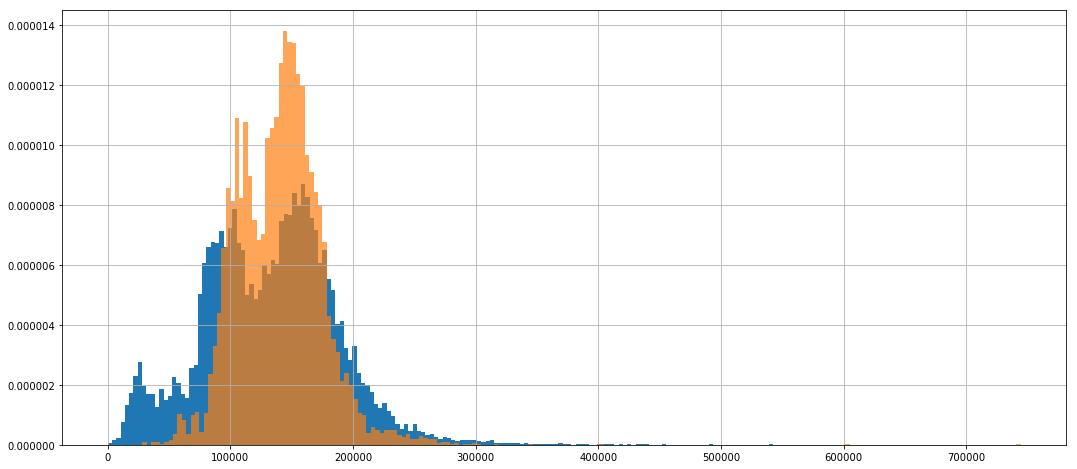

In [64]:
per_sqm_df['rub_per_sqm'][per_sqm_df['rub_per_sqm']<800000].hist(figsize=(18,8), normed=True, bins=200)
per_sqm_df1['rub_per_sqm'][per_sqm_df1['rub_per_sqm']<800000].hist(figsize=(18,8), normed=True, alpha=0.7, bins=200)

In [65]:
print('mean price test:',np.mean(subm_df['price_doc']))
#mean price test: 7318207.51553 - 0.32791

mean price test: 7479643.48108
